In [1]:
import numpy as np
import trimesh
import sys
from typing import List 
from IPython.display import clear_output
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Concatenate,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Parser,
    PointCloud,
    RigidTransform,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
    Context,
    Diagram,
    PointCloud,
    Simulator,
    TrajectorySource,
    Solve,
    RotationMatrix,
    MultibodyPlant
)
from pydrake.geometry import Meshcat
from pydrake.multibody import inverse_kinematics

from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation import running_as_notebook
from manipulation.scenarios import AddFloatingRpyJoint, AddRgbdSensors, ycb, AddMultibodyTriad, MakeManipulationStation
from manipulation.utils import ConfigureParser
from manipulation.clutter import GraspCandidateCost, GenerateAntipodalGraspCandidate
from manipulation.icp import IterativeClosestPoint
from manipulation.station import AddPointClouds

# Own utils
from hwstation.add_objects import get_library_scenario_data, get_library_scenario_data_without_robot
from enum import Enum


In [2]:
# Start meshcat
try:
    meshcat = Meshcat(7004)
except:
    pass #This error appears if this cell is executed twice (port 7006 is already taken then)

INFO:drake:Meshcat listening for connections at http://localhost:7004


In [3]:
# Get string describing scenario
scenario_data = get_library_scenario_data()

In [9]:
meshcat.Delete()
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.00)

scenario = load_scenario(data=scenario_data)
station = builder.AddSystem(MakeHardwareStation(scenario, meshcat,parser_preload_callback=ConfigureParser))

#parser = Parser(plant)
#ConfigureParser(parser)

# Adding point cloud extractors:
to_point_cloud = AddPointClouds(
    scenario=scenario, station=station, builder=builder, meshcat=meshcat
)

#Connect point clouds with output port:
for idx, name in enumerate(to_point_cloud.keys()):
    builder.ExportOutput(
        to_point_cloud[name].get_output_port(), name+"_ptcloud")

plant.Finalize()
visualizer = MeshcatVisualizer.AddToBuilder(builder, station.GetOutputPort("query_object"), meshcat)
diagram = builder.Build()
diagram.set_name("plant and scene_graph")
simulator = Simulator(station)

#Fix desired state of mobile iiwa to be the initial position
sim_context = simulator.get_mutable_context()
x0 = station.GetOutputPort("mobile_iiwa.state_estimated").Eval(sim_context)
station.GetInputPort("mobile_iiwa.desired_state").FixValue(sim_context, x0)

simulator.AdvanceTo(1.0)
    

In [11]:
diagram_context = diagram.CreateDefaultContext()

In [14]:
import pydot
pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()

udp_read_packet -- select:: Interrupted system call
udp_read_packet -- select:: Interrupted system call
udp_read_packet -- select:: Interrupted system call
udp_read_packet -- select:: Interrupted system call


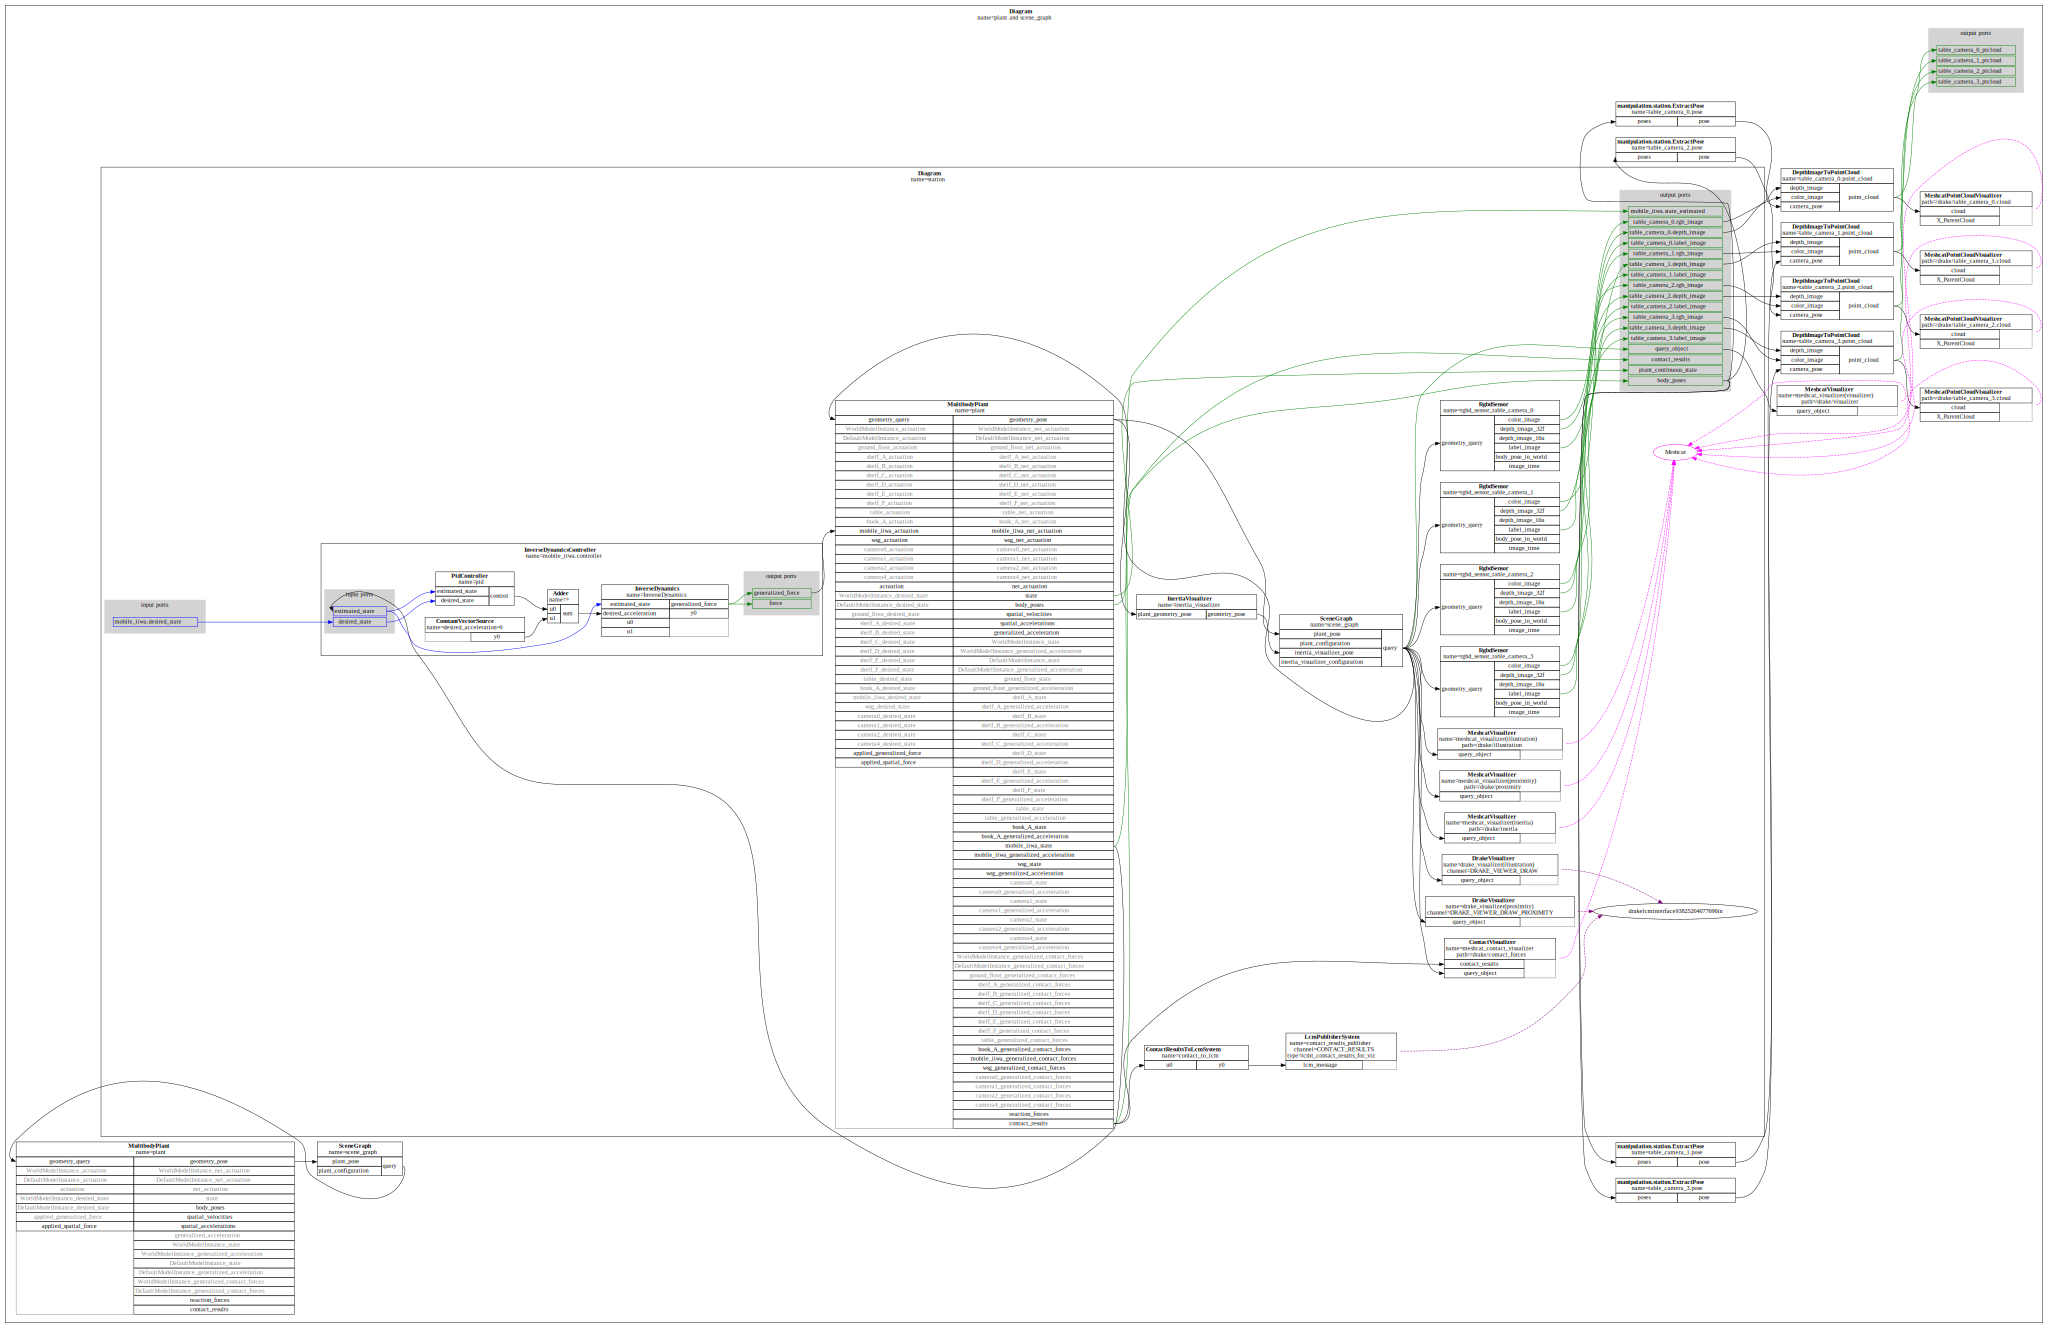

In [12]:
from hwstation.utils import visualize_diagram
visualize_diagram(diagram)